In [1]:
import os
import re
import nltk
import json
import random
from typing import List, Dict
from collections import defaultdict
import statistics
import matplotlib.pyplot as plt

nltk.download('punkt')

def clean_and_check_text(webpage_text: str, unwanted_patterns: List[re.Pattern]) -> str:
    if webpage_text == "NA":
        return webpage_text, True

    # Replace two or more newlines with a single newline
    cleaned_text = re.sub(r'\n{2,}', '\n', webpage_text)

    # Check if any of the unwanted patterns matches the text
    flag = False
    for pattern in unwanted_patterns:
        if pattern.search(cleaned_text):
            flag = True
            break
    return cleaned_text, flag

def load_unwanted_patterns(config_path: str) -> List[re.Pattern]:
    with open(config_path, "r") as f:
        patterns = json.load(f)
    return [re.compile(pattern, re.IGNORECASE | re.MULTILINE) for pattern in patterns]


files = ["outputs/webpages/" + f for f in os.listdir("outputs/webpages") if f.endswith(".json")]
compiled_patterns = load_unwanted_patterns("unwanted_config.json")

[nltk_data] Downloading package punkt to /Users/abz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
with open("outputs/webpages/webpage_4.json", "r") as file:
    data = json.load(file)

Helper Functions

In [23]:
def extract_domain(source_url: str) -> str:
    """
    Extracts the domain from the webpage text.

    Assumes the first line of the text is the URL.
    Returns 'NA' if the text is unavailable or 'Unknown Domain' if extraction fails.
    """
    try:
        # Extract the first line as URL
        url = source_url.split("\n")[0]
        # Use regex to extract domain
        domain_match = re.findall(r'https?://([^/]+)/?', url)
        if domain_match:
            return domain_match[0]
        else:
            return "Unknown Domain"
    except Exception as e:
        return "Failed/NA"
    
def get_top_domains(stats_by_domain: Dict[str, Dict[str, float]], top_n: int = 10) -> List[str]:
    """
    Retrieves the top N domains with the most webpages.
    """
    sorted_domains = sorted(stats_by_domain.items(), key=lambda item: item[1]['average_num_sentences'], reverse=True)
    top_domains = [domain for domain, stats in sorted_domains[:top_n]]
    return top_domains


def compute_stats_by_domain(files: List[str], compiled_patterns: List[re.Pattern]) -> Dict[str, Dict[str, float]]:
    """
    Computes statistical metrics for each domain.

    Parameters:
    - files: List of file paths containing webpage texts.

    Returns:
    A dictionary where each key is a domain and its value is another dictionary of statistics:
    - average_num_sentences
    - median_num_sentences
    - stddev_num_sentences
    - average_sentence_length
    - median_sentence_length
    - stddev_sentence_length
    """
    domain_stats = defaultdict(lambda: {
        'num_sentences': [],
        'sentence_lengths': []
    })
    
    for file_path in files:
        with open(file_path, "r") as file:
            data = json.load(file)
            cleaned_text, flag = clean_and_check_text(data['text'], compiled_patterns)
            
            if flag:
                domain = "Failed/NA"
            else:
                domain = extract_domain(data['source'])
            
            if domain in ["Failed/NA", "Unknown Domain"]:
                continue  # Optionally, you can log or handle failed cases differently
            
            sentences = nltk.sent_tokenize(cleaned_text)
            domain_stats[domain]['num_sentences'].append(len(sentences))
            domain_stats[domain]['sentence_lengths'].extend([len(sentence) for sentence in sentences])
    
    # Compute statistics for each domain
    stats_by_domain = {}
    for domain, data in domain_stats.items():
        if data['num_sentences']:
            stats_by_domain[domain] = {
                'average_num_sentences': sum(data['num_sentences']) / len(data['num_sentences']),
                'median_num_sentences': statistics.median(data['num_sentences']),
                'stddev_num_sentences': statistics.stdev(data['num_sentences']) if len(data['num_sentences']) > 1 else 0,
                'average_sentence_length': sum(data['sentence_lengths']) / len(data['sentence_lengths']),
                'median_sentence_length': statistics.median(data['sentence_lengths']),
                'stddev_sentence_length': statistics.stdev(data['sentence_lengths']) if len(data['sentence_lengths']) > 1 else 0
            }
    
    return stats_by_domain


def compute_stats_full(files: List[str], compiled_patterns: List[re.Pattern]):
    num_sentences = []
    sentence_lengths = []
    for file_path in files:
        with open(file_path, "r") as file:
            data = json.load(file)
            cleaned_text, flag = clean_and_check_text(data['text'], compiled_patterns)

            if flag:
                continue
            sentences = nltk.sent_tokenize(cleaned_text)
            num_sentences.append(len(sentences))
            sentence_lengths.extend([len(sentence) for sentence in sentences])
    return {'all_files': {'num_sentences': num_sentences, 'sentence_lengths': sentence_lengths}}
    
    print("Average # of sentences: ", sum(num_sentences) / len(num_sentences))
    print("Median sentences: ", statistics.median(num_sentences))
    print("Standard deviation: ", statistics.stdev(num_sentences))

    print("Average characters in a sentence: ", sum(sentence_lengths) / len(sentence_lengths))
    print("Median sentence length: ", statistics.median(sentence_lengths))
    print("Standard deviation: ", statistics.stdev(sentence_lengths))

def log_failed_crawls(files: List[str], compiled_patterns: List[re.Pattern], log_file: str = "failed_crawls.log"):
    """
    Logs the file paths of webpages that failed to load or were blocked.

    Parameters:
    - files: List of file paths containing webpage texts.
    - compiled_patterns: List of compiled regex patterns to filter unwanted texts.
    - log_file: Path to the log file where failed crawls will be recorded.
    """
    with open(log_file, "w") as log:
        for file_path in files:
            with open(file_path, "r") as file:
                text = file.read()
                cleaned_text, flag = clean_and_check_text(text, compiled_patterns)
                
                if flag:
                    log.write(f"{file_path}: {'Flagged by pattern' if flag else 'Text unavailable (NA)'}\n")


def plot_sentence_distribution(stats_by_domain: Dict[str, Dict[str, float]]):
    """
    Plots the distribution of the number of sentences per domain using box plots.

    Parameters:
    - stats_by_domain: Dictionary containing statistics grouped by domain.
    """
    domains = list(stats_by_domain.keys())
    num_sentences = [stats['average_num_sentences'] for stats in stats_by_domain.values()]
    
    plt.figure(figsize=(12, 8))
    plt.boxplot(num_sentences, vert=False)
    plt.xlabel('Average Number of Sentences')
    plt.title('Distribution of Average Sentence Counts per Domain')
    plt.yticks([1], ['All Domains'])
    plt.show()

In [5]:
text_cleaned, flag = clean_and_check_text(data['text'], compiled_patterns)
extract_domain(data['source'])

'Unknown Domain'

In [7]:
flag

True

In [14]:
with open ("test_nltk.txt", "w") as file:
    lines = nltk.sent_tokenize(text_cleaned)
    for line in lines:
        file.write(line)

In [30]:
with open("test.txt", "w") as file:
    file.write(text_cleaned)
# Import helper functions

In [33]:
# Compute statistics grouped by domain
stats_by_domain = compute_stats_by_domain(files, compiled_patterns)
top_domains = get_top_domains(stats_by_domain, top_n=10)
print("Top 10 Domains:")
for domain in top_domains:
    print(domain)

stats_full = compute_stats_full(files, compiled_patterns)

Top 10 Domains:
www.iheart.com
jamanetwork.com
www.theguardian.com
dx.doi.org
bmcpublichealth.biomedcentral.com
freedomhouse.org
www.cdc.gov
www.ncbi.nlm.nih.gov
pubmed.ncbi.nlm.nih.gov
africacheck.org


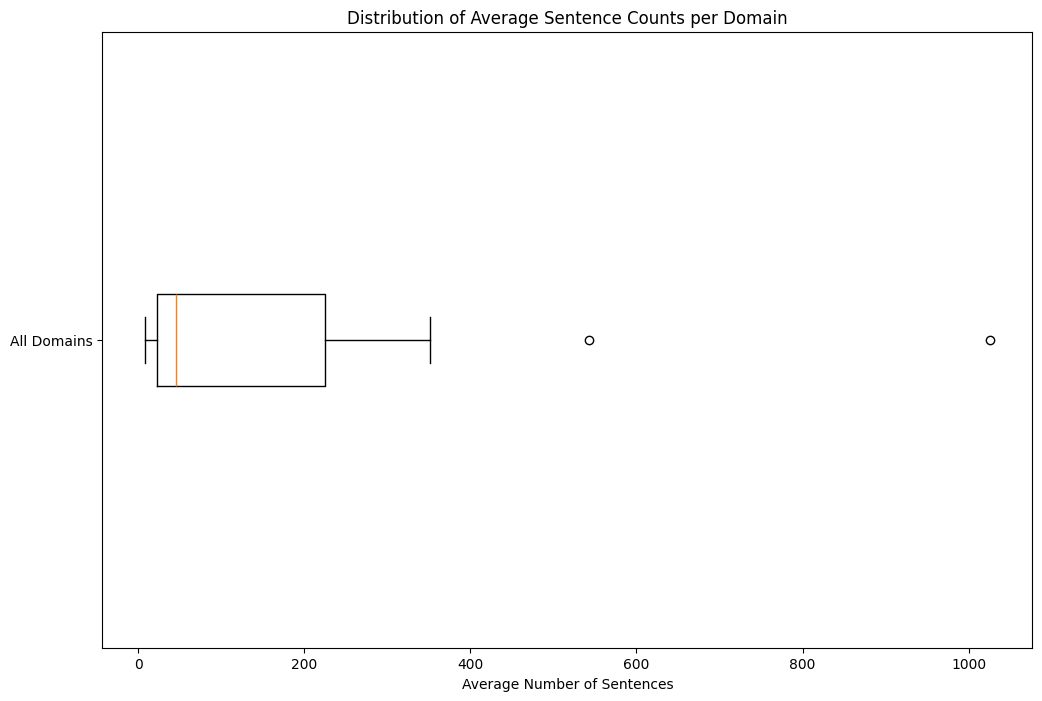

In [34]:
plot_sentence_distribution(stats_by_domain)

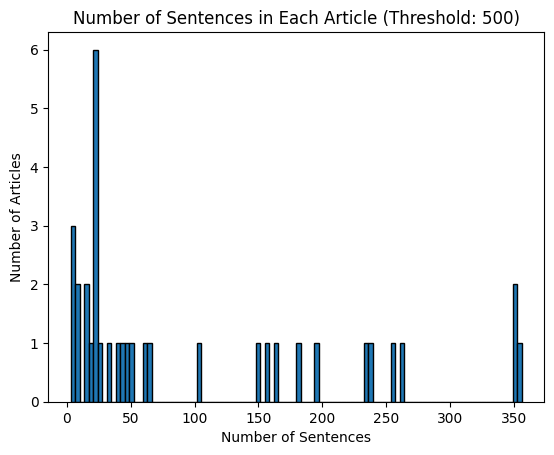

In [30]:
# Generate a histogram of number of sentences in x-axis and number of articles in y-axiss
thresh = 500
num_sentences_filtered = [ns for ns in stats_full['all_files']['num_sentences'] if ns <= thresh]

plt.hist(num_sentences_filtered, bins=100, edgecolor='black')
# Normalize the histogram
plt.title(f'Number of Sentences in Each Article (Threshold: {thresh})')
plt.xlabel('Number of Sentences')
plt.ylabel('Number of Articles')
plt.show()

In [11]:
num_articles = len([length for length in num_sentence if length <= 100])
print("Percentage of articles:", num_articles / len(num_sentence) * 100, "%")

Percentage of articles: 61.421911421911425 %


In [8]:
# Print an article whose length is less than 10
random.shuffle(files)
for file_path in files:
    with open(file_path, "r") as file:
        text = file.read()
        cleaned_text, flag = clean_and_check_text(text, compiled_patterns)
        sentences = nltk.sent_tokenize(cleaned_text)
        if flag and len(sentences) <= 1000:
            print("Skipping this article")
            print(cleaned_text, "\n------\n")
            continue
        
        # article_length = len(sentences)
        # if article_length <= 5:
        #     print(text)
        #     break

Skipping this article

Something went wrong. Wait a moment and try again.
Try again
Please enable Javascript and refresh the page to continue 
------

Skipping this article

Something went wrong. Wait a moment and try again.
Try again
Please enable Javascript and refresh the page to continue 
------

Skipping this article

Sorry, we just need to make sure you're not a robot. For best results, please make sure your browser is accepting cookies. 
------

Skipping this article

# Your Browser is out of date.
Update your browser to view ScienceDirect.
Request details:
**Request ID:**8ce2e2eaeef65e74-IAD
**IP:**156.57.112.15
**UTC time**: 2024-10-06T04:25:14+00:00
**Browser**: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/85.0.4183.102 Safari/537.36 
------

Skipping this article

Something went wrong. Wait a moment and try again.
Try again
Please enable Javascript and refresh the page to continue 
------

Skipping this article

Something went wrong

In [ ]:
'''Something went wrong. Wait a moment and try again.
Try again
Please enable Javascript and refresh the page to continue'''

------

'''Sorry, we just need to make sure you're not a robot. For best results, please make sure your browser is accepting cookies.'''

------

'''# Your Browser is out of date.

Update your browser to view ScienceDirect.

Request details:

**Request ID:**8ce2e1025e654405-IAD

**IP:**156.57.112.15

**UTC time**: 2024-10-06T04:23:56+00:00

**Browser**: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/85.0.4183.102 Safari/537.36'''

'''
An official website of the United States government

Here’s how you know

**
Official websites use .gov
**

A **.gov** website belongs to an official government organization in the United States.

**
Secure .gov websites use HTTPS
**

A **lock** (
) or **https://** means you’ve safely connected to the .gov website. Share sensitive
information only on official, secure websites.
'''

'''
Facebook
Facebook is not available on this browser
To continue using Facebook, get one of the browsers below.
Learn more
English (US)
+
Meta © 2024
'''

------

'''
Facebook
Facebook is not available on this browser
To continue using Facebook, get one of the browsers below.
Learn more
English (US)
+
Meta © 2024
'''

-----

'''
Reference ID b38a0d9c-839a-11ef-8b1d-2e8e705193d8

Report a problem

Experiencing issues with this page? please let us know:

You can contact us for assistance. You should use Ref ID:

b38a0d9c-839a-11ef-8b1d-2e8e705193d8

You can also send us your feedback:

✓Thank you for the feedback'''